# RBF


We choose a gaußian activation function for a RBF neuron with it's derivatives $$y(x)=e^{-\frac{||x - c||^2}{2\sigma^2}}$$
$$\frac d{dc}y(x)=\frac{x-c}{\sigma^2}e^{-\frac{||x - c||^2}{2\sigma^2}}$$
$$\frac d{dx}y(x)=-\frac{x-c}{\sigma^2}e^{-\frac{||x - c||^2}{2\sigma^2}}$$

# Experiments


The MNIST data set can be downloaded in *.CSV* [this](https://github.com/pjreddie/mnist-csv-png/blob/master/process_mnist.py) git repository.

## RBF

### Boolean Function

Training model for 1000 epochs over 4 training examples.
Epoch 1000/1000 | Epoch Duration: 0.00s | Average Error: 0.04| 100% |████████████████████████████████████████████████████████████████████████████████████████████████████|
Finished training in 0.488828182220459 seconds.
Predicting 4 inputs.
Input 4/4| 100% |████████████████████████████████████████████████████████████████████████████████████████████████████|
Output: 0.05544355490179344	Expected: 0.0
Output: 0.96440879849826	Expected: 1.0
Output: 0.0028028472158030597	Expected: 0.0
Output: 0.05226786042684136	Expected: 0.0


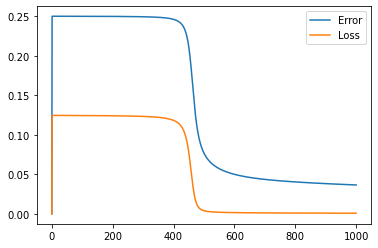

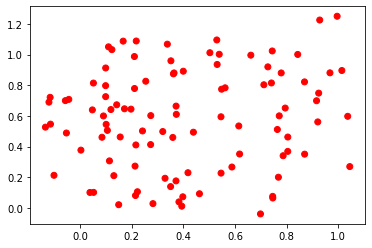

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import layer
from neurons import RBF
from typing import List
import model

TRAIN_RATE:float = 0.01
TRAIN:bool = True
FIRST_LAYER_NEURONS:int = 100
TRAINING_REPITIONS:int = 1000

layers:List[layer.DenseLayer] = []
layers.append(layer.DenseLayer(2, FIRST_LAYER_NEURONS, RBF))
layers.append(layer.DenseLayer(FIRST_LAYER_NEURONS, 1, RBF))

m = model.Model(layers)

inputs = np.array([[0.0,0.0],[1.0,0.0],[0.0,1.0],[1.0,1.0]])
expected = np.array([0.0, 1.0, 0.0, 0.0])

if TRAIN:
    m.train(inputs, expected, TRAINING_REPITIONS)

    plt.plot(m.errors, label='Error')
    plt.plot(m.losses, label='Loss')
    plt.legend()

for i, output in enumerate(m.predict(inputs)):
    print(f"Output: {output[0]}\tExpected: {expected[i]}")

pts = np.empty((FIRST_LAYER_NEURONS, 2))
colours = np.empty((FIRST_LAYER_NEURONS,3))
pts = layers[0].neuron_data
colours[:] = np.array([1.0,0.0,0.0])
plt.figure()
plt.scatter(pts[:,0], pts[:,1],c=colours)




### MNIST

In [1]:
'''Load data'''
import numpy as np
from pathlib import Path
from typing import Tuple

def load_mnist(path:Path) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Returns:
        labels, images
    '''
    raw_data:np.ndarray = np.loadtxt(path, delimiter=",")
    indices = np.arange(raw_data.shape[0])
    np.random.shuffle(indices)
    return raw_data[indices,0].astype(int), raw_data[indices,1:] / 255.0

def create_one_hot_encoding(labels:np.ndarray)->np.ndarray:
    '''
    Creates a one hot encoding of the labels.

    Assumes the labels start from 0.
    '''
    indices = np.empty((2, labels.shape[0]), dtype=int)
    indices[0,:] = np.arange(labels.shape[0])
    indices[1,:] = labels
    num_labels = np.max(labels + 1)
    encoded_labels = np.zeros((labels.shape[0], num_labels))
    encoded_labels[indices[0], indices[1]] = 1.0
    return encoded_labels

train_labels, train_data = load_mnist(Path("mnist_train.csv"))
train_labels = create_one_hot_encoding(train_labels)

validation_labels, validation_data = load_mnist((Path("mnist_test.csv")))
validation_labels = create_one_hot_encoding(validation_labels)

In [2]:
'''Create a model'''
from typing import List
import numpy as np
import layer
import model
from neurons import RBF
import loss


FIRST_LAYER_NEURONS:int = 50
NUM_LABELS:int = 10

layers:List[layer.DenseLayer] = []
layers.append(layer.DenseLayer(train_data.shape[1], FIRST_LAYER_NEURONS, RBF))
layers.append(layer.DenseLayer(FIRST_LAYER_NEURONS, NUM_LABELS, RBF))

m = model.Model(layers)

In [3]:
'''Train the model.'''
from matplotlib import pyplot as plt

TRAINING_REPITIONS:int = 50
TRAIN_RATE:float = 0.1

m.train(train_input=train_data, train_output=train_labels, epochs=TRAINING_REPITIONS, train_rate=TRAIN_RATE, loss_function=loss.quadratic_error)
print(f"Last error {m.errors[-1]}")

Training model for 50 epochs over 60000 training examples.


In [ ]:
print(f"Average validation error: {m.validate(validation_data, validation_labels)}.")

Predicting 10000 inputs.
Input 10000/10000| 100% |████████████████████████████████████████████████████████████████████████████████████████████████████|
Validtaing outputs.
Average validation error: 0.8257162146942357.


In [ ]:
output = m.predict(validation_data)
labels = np.argmax(output,axis=1)

mask = labels == np.argmax(validation_labels,axis=1)

print(f"Classified {np.sum(mask)} out of {validation_data.shape[0]} correctly.")

Predicting 10000 inputs.
Input 10000/10000| 100% |████████████████████████████████████████████████████████████████████████████████████████████████████|
Classified 1135 out of 10000 correctly.
